Analysis of numbers of bicyclists crossing Brooklyn bridge everyday considering some factors that may act towards such counts

In [32]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [33]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [34]:
nyc_df = pd.read_csv("/content/nyc_bb_bicyclist_counts.csv", index_col=[0], parse_dates=[0], infer_datetime_format=True)
nyc_df.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807


**Adding day, month and day of the week to the dataset to make our independent variable robust**

In [35]:
dataset = nyc_df.index.to_series()
nyc_df['MONTH'] = dataset.dt.month
nyc_df['DAY_OF_WEEK'] = dataset.dt.dayofweek
nyc_df['DAY'] = dataset.dt.day

In [36]:
nyc_df

,HIGH_T,LOW_T,PRECIP,BB_COUNT,MONTH,DAY_OF_WEEK,DAY
Date,,,,,,,
2017-04-01,46.0,37.0,0.00,606,4,5,1
2017-04-02,62.1,41.0,0.00,2021,4,6,2
2017-04-03,63.0,50.0,0.03,2470,4,0,3
2017-04-04,51.1,46.0,1.18,723,4,1,4
2017-04-05,63.0,46.0,0.00,2807,4,2,5
...,...,...,...,...,...,...,...
2017-10-27,62.1,48.0,0.00,3150,10,4,27
2017-10-28,68.0,55.9,0.00,2245,10,5,28
2017-10-29,64.9,61.0,3.03,183,10,6,29


In [37]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 214 entries, 2017-04-01 to 2017-10-31
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HIGH_T       214 non-null    float64
 1   LOW_T        214 non-null    float64
 2   PRECIP       214 non-null    float64
 3   BB_COUNT     214 non-null    int64  
 4   MONTH        214 non-null    int64  
 5   DAY_OF_WEEK  214 non-null    int64  
 6   DAY          214 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 13.4 KB


splitting the dataset into train and test

In [38]:
mask = np.random.rand(len(nyc_df)) < 0.80

train = nyc_df[mask]
test  = nyc_df[~mask]

print("training dataset length is :" + str(len(train)))
print("testing dataset length is :" + str(len(test)))

training dataset length is :172
testing dataset length is :42


Here We are telling patsy which is a library in pthon that BB_COUNT is our dependent variable y and it is being explained by the independent variables X: DAY, DAY_OF_WEEK, MONTH, HIGH_T, LOW_T and PRECIP.

In [39]:
expr = 'BB_COUNT ~ DAY + DAY_OF_WEEK + MONTH + BB_COUNT + PRECIP + LOW_T + HIGH_T'

We’ll use Patsy to carve out the X and y matrices. Patsy will automatically add a regression intercept column to X:

In [40]:
y_train, X_train = dmatrices(expr, train, return_type="dataframe")
y_test, X_test = dmatrices(expr, test, return_type="dataframe")

**Using the Generalized Linear Model to train**

In [41]:
glm_poisson = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(glm_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               BB_COUNT   No. Observations:                  172
Model:                            GLM   Df Residuals:                      164
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2332.5
Date:                Fri, 02 Jul 2021   Deviance:                       3006.0
Time:                        09:57:25   Pearson chi2:                 2.69e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.6554      0.014    492.655      

From the Model above we can see DAY_OF_WEEK and MONTH are not statistically significant(p-value:0.412 & 0.119) while the remaining variables are statistically significant at the 95% confidence since their p-value is < 0.05 

      **Assumption of Poisson Distribution**
Following poisson assumption that an event happening should not be as result of an already existen event and in other to avoid overdispersion which arises when the ni Bernoulli trials that are summarized in a line of the dataset are:

a. not identically distributed (i.e. the success probabilities vary from one trial to the next), or

b. not independent (i.e. the outcome of one trial influences the outcomes of other trialst

**checking for the mean and variance to see if it confirms to the assumptions above**

In [42]:
print('variance :' + str(nyc_df['BB_COUNT'].var()))
print('mean :' + str(nyc_df['BB_COUNT'].mean()))

variance :730530.6601948135
mean :2680.042056074766


From the computation above we can tell that the variance is much more high than the mean which goes contrary to the assuption of the poisson distribution. So we’ll build and train GP-1(Generalized Poisson Regression) model next and see if it performs better.

In [43]:
gp1_poisson = sm.GeneralizedPoisson(y_train, X_train, p=1)
gp1_poisson_model = gp1_poisson.fit()

         Current function value: 7.348058
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4


/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1396: RuntimeWarning: divide by zero encountered in log
  np.log(a1) - gammaln(endog + 1) - a2 / a1)
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1531: RuntimeWarning: divide by zero encountered in reciprocal
  a3 = alpha * p * mu ** (p - 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1531: RuntimeWarning: overflow encountered in reciprocal
  a3 = alpha * p * mu ** (p - 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1531: RuntimeWarning: invalid value encountered in multiply
  a3 = alpha * p * mu ** (p - 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1539: RuntimeWarning: divide by zero encountered in true_divide
  1 / mu)
/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1539: RuntimeWarning: overflow encountered in true_divide
  1 / mu)
/usr/local

In [44]:
print(gp1_poisson_model.summary())

                    GeneralizedPoisson Regression Results                     
Dep. Variable:               BB_COUNT   No. Observations:                  172
Model:             GeneralizedPoisson   Df Residuals:                      164
Method:                           MLE   Df Model:                            7
Date:                Fri, 02 Jul 2021   Pseudo R-squ.:                  0.1447
Time:                        09:57:25   Log-Likelihood:                -1263.9
converged:                      False   LL-Null:                       -1477.7
Covariance Type:            nonrobust   LLR p-value:                 2.799e-88
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.6554      0.034    196.088      0.000       6.589       6.722
DAY             0.0002      0.000      0.434      0.664      -0.001       0.001
DAY_OF_WEEK    -0.0002      0.002     -0.110    

From the GeneralizedPoisson Regression result DAY, DAY_OF_MONTH, MONTH variables coefficient are not statistically significant at 95% confidence interval that is the p-value is > 0.05. Recall that in the Generalized Linear model all variables apart from DAY_OF_MONTH and MONTH are not statistically significant at 95% confidence interval.


**Goodness-of-fit of the GP-1 model**

The GP-1 model’s Maximum Likelihood Estimate is -1263.9 which is less than that of the null-model’s MLE of -2332.5. The null model is a simple intercept-only model, i.e. a horizontal line passing through the y-intercept. But is the difference statistically significant? The Likelihood Ratio (LR) test’s p-value is shown to be 2.799e-88, an extremely tiny number. So yes, the GP-1 model does actually do a better job of modeling the data than a simple intercept-only model.

**Prediction**

In [45]:
gp1_predict = gp1_poisson_model.predict(X_test)

**Plotting graph to show the predictions from the actual**

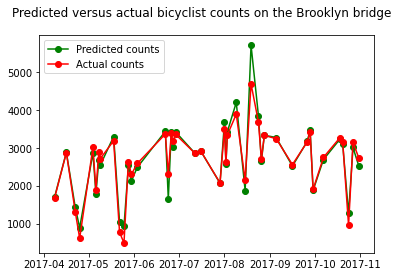

In [49]:
predicted_counts = gp1_predict
actual_counts = y_test['BB_COUNT']

fig = plt.figure()

fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

The graph above shows the prediction of cyclist compare to the actual counts 

**Ends of NoteBook**